In [316]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, TruncatedSVD, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import rand_score
from ucimlrepo import fetch_ucirepo 
from scipy.stats import zscore

#### 1. Classification Problem Idenitification

Chronic Kidney Disease (CKD) is the progressive loss of kindey function (@sanmarchi2023predict). The progression of the disease can be attributed to a number of factors. The implications of CKD are large, especially for the quality of life of those afflicted as well as for the sustainability of national health systems (@sanmarchi2023predict). Thus, it is important to use the information available about patient health to predict the diagnosis of CKD.

The dataset from the Early Stage of Indians Chronic Kidney Disease (CKD) project (@misc_chronic_kidney_disease_336) contains information on a variety of health factors, including blood pressure, red blood cell count, albumin concentration, blood sugar, whether or not one has diabetes mellitus, and more.

This dataset will be used to predict whether an individual will develop CKD. 

In [317]:
chronic_kidney_disease = fetch_ucirepo(id=336) 
x = chronic_kidney_disease.data.features 
y = chronic_kidney_disease.data.targets 

ckd = pd.DataFrame(x)
target = pd.DataFrame(y)

df = pd.concat([ckd,target], axis = 1)
df = pd.DataFrame(df)

df.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
5,60.0,90.0,1.015,3.0,0.0,NaN,NaN,notpresent,notpresent,74.0,...,39.0,7800.0,4.4,yes,yes,no,good,yes,no,ckd
6,68.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,100.0,...,36.0,NaN,NaN,no,no,no,good,no,no,ckd
7,24.0,NaN,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,410.0,...,44.0,6900.0,5.0,no,yes,no,good,yes,no,ckd
8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,138.0,...,33.0,9600.0,4.0,yes,yes,no,good,no,yes,ckd
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,ckd


The `ckd` dataframe only contains the variables that we will be using to predict `class`.
The `target` dataframe contains what we are predicting (`class`).

### 2. Variable Transformation

Based on the variable types, there are some variables that are numerical, while others are categorical variables. 

In terms of variable transformations, we need to scale and standardize all continuous variables (float64) and also convert categorical variables to numerical. This should be done after removing missing values.

Any other variable transformations should not be applied in this case as the data set's numerical variables hold meaning as their original values.

For now, we will simply take the `class` variable (the response) and convert it into a categorical variable.

In [318]:
df.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class     object
dtype: object

In [319]:
df['class'].value_counts() # ckd\t assignment instead of ckd so we need to correct it
cl = df['class'].str.replace('ckd\t','ckd')
df['class'] = cl
df['class'].value_counts()

# Converting Class variable to categorical (predictor)
df['class'] = pd.Categorical(
    df['class'], 
    categories=["notckd", "ckd"], 
    ordered=True
    )
df['class'] = df['class'].cat.codes
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,1
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,1
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,1
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,1
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,1


### 3. Dataset Overview

In [320]:
df.shape

(400, 25)

In [321]:
df.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class       int8
dtype: object

In [322]:
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,class
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000,400.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435,0.625000
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323,0.484729
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000,0.000000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000,0.000000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000,1.000000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000,1.000000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000,1.000000


In [323]:
df.describe(include=object)

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane
count,248,335,396,396,398,398,398,399,399,399
unique,2,2,2,2,2,3,2,2,2,2
top,normal,normal,notpresent,notpresent,no,no,no,good,no,no
freq,201,259,354,374,251,260,364,317,323,339


In [324]:
df.dm.value_counts()

dm
no      260
yes     137
\tno      1
Name: count, dtype: int64

In [325]:
dm = df.dm
dm = dm.str.replace('\tno','no')
dm.value_counts()

df.dm = dm
df.dm.value_counts()

dm
no     261
yes    137
Name: count, dtype: int64

The `dm` variable, which indicates whether an individual has diabetes mellitus, has an error term where instead of just 'no', the entry is '\tno' so we've corrected that by changing it back to 'no'.

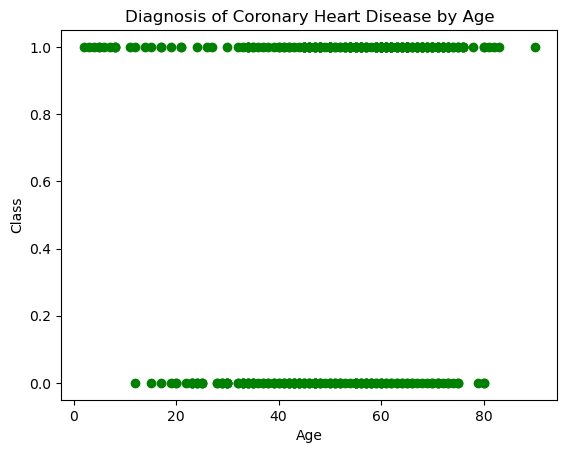

In [326]:
plt.scatter(df['age'], df['class'], color = 'green')
plt.title('Diagnosis of Coronary Heart Disease by Age')
plt.xlabel('Age')
plt.ylabel('Class')
plt.show()

There are 400 observations and 24 variables, out of which 14 are numerical and 10 are nominal (listed above). There are also many missing values in many variable categories, which is why all of the variable counts are not equal to 400. Since the class variable was transformed (earlier in question 2), it takes on values of 1 and 0, indicating whether an individual has ckd (1) or not (0), as seen in the scatter plot for values Class vs Age.

### 4. Association between Variables

We will create a correlation matrix to visualize the association between variables.

<Axes: >

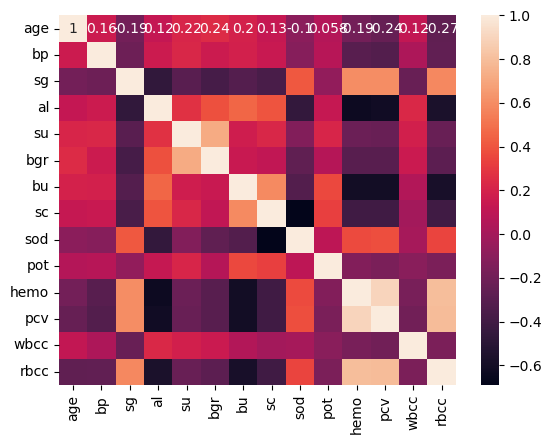

In [327]:
ckd_excluded = ckd.select_dtypes(
    include = ['float64']
    )


sns.heatmap(ckd_excluded.corr(), annot=True)

Some variables have little relationship, such as serum creatine adn white blood cell count, as indicated with a coefficient of correlation of about 0.0. However, other variables, such as red blood cell count and hemoglobin have a very strong positive correlation, and others such as albumin and red blod cell count have a strong negative correlation.

Since it appaers that there is co-linearity, the presence of strong linear relationships among predictor variables, the regression coefficients generated by a logistic regression model, for instance, would have large sampling errors. Feature selection should seek to remove some predictor variables that are correlated to reduce co-linearity.

### 5. Missing Value Analysis and Handling

In [328]:
num = ckd.select_dtypes(
    include = ['float64']
    ).columns

cat_columns = ckd.select_dtypes(
    include=['object']
    ).columns

print(ckd[cat_columns].isna().sum())
print(ckd[num].isna().sum())

rbc      152
pc        65
pcc        4
ba         4
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64
age       9
bp       12
sg       47
al       46
su       49
bgr      44
bu       19
sc       17
sod      87
pot      88
hemo     52
pcv      71
wbcc    106
rbcc    131
dtype: int64


In [329]:
df['class'].isna().sum()

0

We see that there are a lot of missing values for multiple variables. Simply deleting these entries would result in the loss of far too much data and to set these missing values as 0 would change the interpretation for the values of each variable. However, the `class` variable has no missing values, so we do not have to remove any missing values.

In [330]:
# Standardize and Scaling Variables
num = ckd.select_dtypes(
    include = ['float64']
    ).columns

scaler = StandardScaler()
ckd[num] = scaler.fit_transform(ckd[num])

# Nominal to Categorical Variables
cat_columns = ckd.select_dtypes(
    include=['object']
    ).columns

for col in cat_columns:
    ckd[col] = ckd[col].astype('category').cat.codes

### 6. Outlier Analysis and Handling

Outliers will be handled by replacing anything with a z score greater than 3 or less than 3 with the 5th or 95th percentile value respectively. This can help to reduce overfitting. Examination of select boxplots below shows that there are outliers

<Axes: >

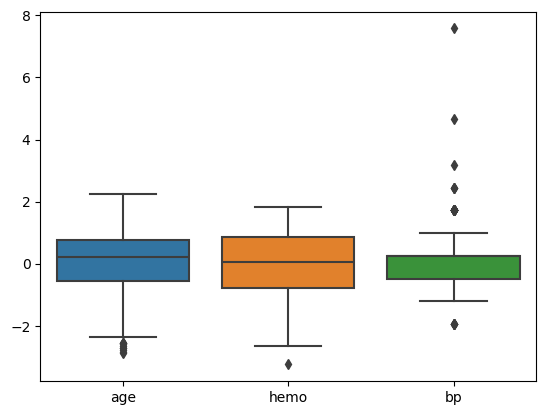

In [331]:
sns.boxplot(ckd[['age', 'hemo', 'bp']])

In [332]:
ckd = ckd.dropna(subset=num)

for col in num:
    z_scores = zscore(ckd[col])
    print(z_scores)
    outliers = z_scores > 3
    ckd.loc[outliers, col] = ckd[col].quantile(0.95)
    outliers = z_scores < - 3
    ckd.loc[outliers, col] = ckd[col].quantile(0.05)


3     -0.247206
5      0.521879
9      0.073246
11     0.714150
12     1.034602
         ...   
395    0.201427
396   -0.631748
397   -2.554460
398   -2.234008
399    0.393698
Name: age, Length: 203, dtype: float64
3     -0.428141
5      1.310111
9      1.310111
11    -0.428141
12    -0.428141
         ...   
395    0.440985
396   -0.428141
397    0.440985
398   -1.297267
399    0.440985
Name: bp, Length: 203, dtype: float64
3     -2.493056
5     -0.717300
9      0.170577
11    -1.605178
12    -0.717300
         ...   
395    0.170577
396    1.058455
397    0.170577
398    1.058455
399    1.058455
Name: sg, Length: 203, dtype: float64
3      2.342066
5      1.604951
9      0.867835
11     1.604951
12     1.604951
         ...   
395   -0.606395
396   -0.606395
397   -0.606395
398   -0.606395
399   -0.606395
Name: al, Length: 203, dtype: float64
3     -0.370974
5     -0.370974
9     -0.370974
11    -0.370974
12     0.660639
         ...   
395   -0.370974
396   -0.370974
397   -0.370974

In [333]:
ckd

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
3,-0.203139,-0.473370,-2.173584,2.208413,-0.410106,1,0,1,0,-0.392022,...,-0.456071,-0.766953,-0.580420,-0.788961,1,1,0,1,1,1
5,0.496661,0.990117,-0.421814,1.468092,-0.410106,-1,-1,0,0,-0.935155,...,-0.112239,0.012867,-0.206202,-0.300401,1,2,0,0,1,0
9,0.088445,0.990117,0.454071,0.727772,-0.410106,0,0,1,0,-0.985679,...,-1.040585,-1.101161,1.256651,-0.984385,1,2,0,1,0,1
11,0.671612,-0.473370,-1.297699,1.468092,-0.410106,0,0,1,0,1.879032,...,-0.593604,-0.766953,-1.328856,-0.886673,1,2,0,1,1,0
12,0.963195,-0.473370,-0.421814,1.468092,0.500952,-1,1,1,0,0.757399,...,-0.971819,-1.212564,1.290671,-1.277521,1,2,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.205078,0.258373,0.454071,-0.752868,-0.410106,1,1,0,0,-0.101509,...,1.091172,0.904090,-0.580420,0.188159,0,1,0,0,0,0
396,-0.553039,-0.473370,1.329955,-0.752868,-0.410106,1,1,0,0,-0.922524,...,1.366237,1.683910,-0.206202,1.458415,0,1,0,0,0,0
397,-2.302541,0.258373,0.454071,-0.752868,-0.410106,1,1,0,0,-0.606749,...,1.125555,1.126896,-0.614440,0.676719,0,1,0,0,0,0
398,-2.010957,-1.205114,1.329955,-0.752868,-0.410106,1,1,0,0,-0.429915,...,0.575424,1.349701,-0.410321,1.165279,0,1,0,0,0,0


<Axes: >

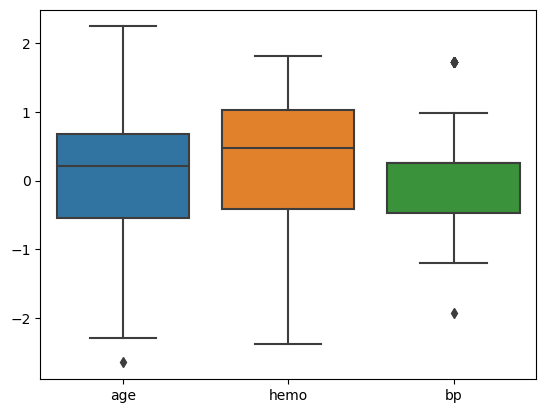

In [334]:
sns.boxplot(ckd[['age', 'hemo', 'bp']])

Many of the previously present outliers have been removed. While there are still some values outside of the whiskets of the plot, these values do not have a z-score greater than 3.

## 7: Subgroup Analysis

Examining the subgroups of patients with or without hypertension, diabetes, or CAD may be of interest. The plots below will specifically visualize how blood pressure varies based on these values.

/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


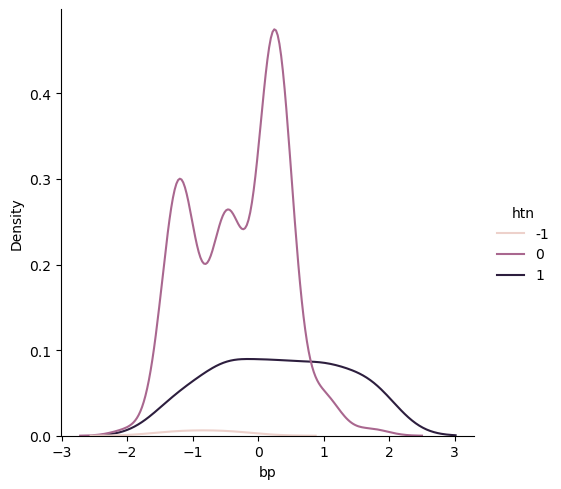

In [335]:
sns.displot(data = ckd, x = 'bp', hue = 'htn', kind = 'kde')

/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


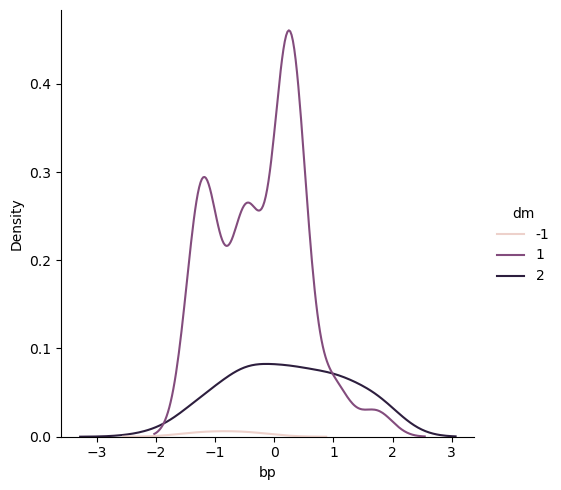

In [336]:
sns.displot(data = ckd, x = 'bp', hue = 'dm', kind = 'kde')

/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


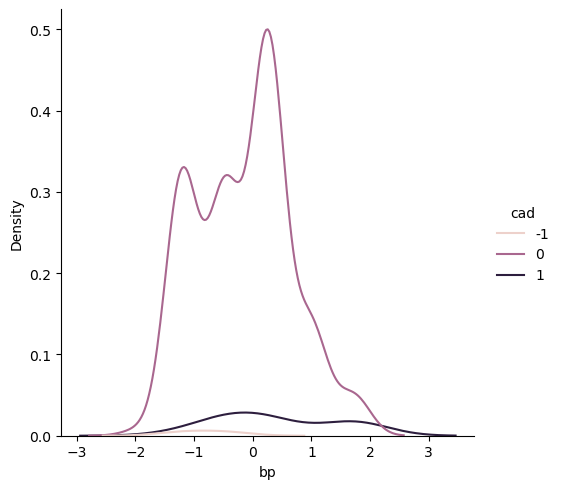

In [337]:
sns.displot(data = ckd, x = 'bp', hue = 'cad', kind = 'kde')